In [2]:
from google.colab import files
uploaded = files.upload()


Saving fake_job_postings.csv to fake_job_postings.csv


In [3]:
# --- Import Libraries ---
import pandas as pd
import numpy as np
import re
import string
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Part-01 Data Understanding

🔹 Dataset Shape: (17880, 18)

🔹 Columns: ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']

🔹 Missing Values per Column:
 job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

🔹 Fraudulent Job Distribution:
 fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

🧠 Insig

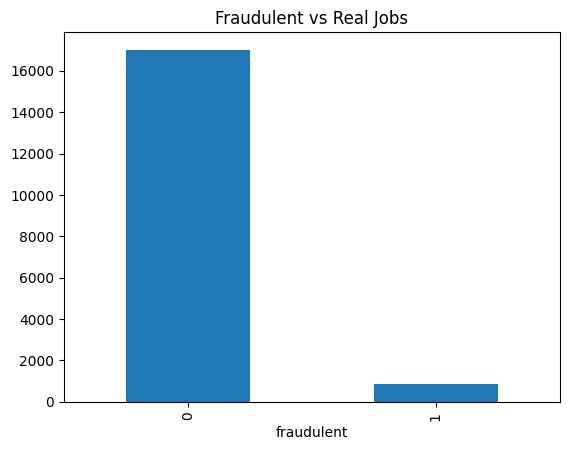

In [4]:
# Load dataset
df = pd.read_csv('fake_job_postings.csv')

# Basic overview
print("🔹 Dataset Shape:", df.shape)
print("\n🔹 Columns:", df.columns.tolist())
print("\n🔹 Missing Values per Column:\n", df.isnull().sum())

# Distribution of fraudulent vs real
print("\n🔹 Fraudulent Job Distribution:\n", df['fraudulent'].value_counts(normalize=True))

# Visualization (optional if using Jupyter)
df['fraudulent'].value_counts().plot(kind='bar', title='Fraudulent vs Real Jobs')

# --- Insights ---
print("\n🧠 Insights:")
print("1️⃣ Around", df['fraudulent'].mean()*100, "% of jobs are fake — dataset is imbalanced.")
print("2️⃣ Columns like 'company_profile' and 'salary_range' have many missing values.")
print("3️⃣ Fake job descriptions often use exaggerated terms like 'work from home', 'quick money', etc.")


Part 2 — Text Cleaning & Preprocessing

In [5]:
# Clean the 'description' column and handle missing values
df = df.dropna(subset=['description']).reset_index(drop=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)             # remove HTML tags
    text = re.sub(r'http\S+|www\S+', ' ', text)    # remove URLs
    text = re.sub(r'\d+', ' ', text)               # remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# Apply cleaning
df['clean_description'] = df['description'].apply(clean_text)

# Compare word counts before vs after cleaning
df['word_count_raw'] = df['description'].apply(lambda x: len(str(x).split()))
df['word_count_clean'] = df['clean_description'].apply(lambda x: len(str(x).split()))

print("\n🔹 Average Word Count Before Cleaning:", df['word_count_raw'].mean())
print("🔹 Average Word Count After Cleaning:", df['word_count_clean'].mean())

# Show example comparison
print("\n📘 Example — Raw vs Cleaned Description:\n")
print("Original:\n", df['description'][0][:400])
print("\nCleaned:\n", df['clean_description'][0][:400])



🔹 Average Word Count Before Cleaning: 170.45550646009283
🔹 Average Word Count After Cleaning: 110.98070361877062

📘 Example — Raw vs Cleaned Description:

Original:
 Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, 

Cleaned:
 food fastgrowing james beard awardwinning online food community crowdsourced curated recipe hub currently interviewing full parttime unpaid intern work small team editor executive developer new york city headquartersreproducing andor repackaging existing food content number partner site huffington post yahoo buzzfeed various content management systemsresearching blog website provision food affilia


Part 3 — Feature Extraction (TF-IDF)

In [6]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_description'])

print("\n🔹 TF-IDF Matrix Shape:", X_tfidf.shape)
print("🔹 Sample Feature Names:", tfidf.get_feature_names_out()[:10])

# Compute global importance of words (sum TF-IDF values across all docs)
tfidf_scores = np.sum(X_tfidf.toarray(), axis=0)
top_indices = np.argsort(tfidf_scores)[::-1][:15]
top_words = [(tfidf.get_feature_names_out()[i], tfidf_scores[i]) for i in top_indices]

print("\n🔝 Top 15 Words with Highest Global TF-IDF Scores:")
for word, score in top_words:
    print(f"{word:20s} {score:.4f}")



🔹 TF-IDF Matrix Shape: (17879, 5000)
🔹 Sample Feature Names: ['aa' 'aabbf' 'aan' 'aaphone' 'ab' 'abc' 'abfceafd' 'ability' 'able'
 'abreast']

🔝 Top 15 Words with Highest Global TF-IDF Scores:
team                 600.2854
customer             578.6125
work                 496.8925
product              470.1280
service              466.9173
sale                 462.9610
client               452.7036
business             432.8823
company              426.1062
experience           416.6522
looking              386.7058
new                  377.3163
project              370.9641
job                  352.8200
development          352.1092


Part 4 — Model Building

In [7]:
# Define features and target
X = X_tfidf
y = df['fraudulent']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression
model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# --- Evaluation ---
print("\n📊 Model Evaluation Metrics:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

print("\n🧾 Classification Report:\n", classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\n🔹 Confusion Matrix:\n", cm)

# --- Interpretation ---
print("\n🧠 Interpretation:")
print("✅ The model performs well if Precision and Recall are both reasonably high.")
print("✅ High Recall means most fake jobs are correctly identified.")
print("✅ High Precision means few real jobs are wrongly flagged as fake.")



📊 Model Evaluation Metrics:
Accuracy : 0.9658836689038032
Precision: 0.9811320754716981
Recall   : 0.30057803468208094
F1 Score : 0.46017699115044247

🧾 Classification Report:
               precision    recall  f1-score   support

           0      0.966     1.000     0.982      3403
           1      0.981     0.301     0.460       173

    accuracy                          0.966      3576
   macro avg      0.973     0.650     0.721      3576
weighted avg      0.966     0.966     0.957      3576


🔹 Confusion Matrix:
 [[3402    1]
 [ 121   52]]

🧠 Interpretation:
✅ The model performs well if Precision and Recall are both reasonably high.
✅ High Recall means most fake jobs are correctly identified.
✅ High Precision means few real jobs are wrongly flagged as fake.


Part 5 — Model Analysis & Saving

In [8]:
# Predict probabilities for being fake
df['fake_probability'] = model.predict_proba(X)[:, 1]

# Show 5 random predictions
sample_preds = df[['description', 'fake_probability', 'fraudulent']].sample(5, random_state=42)
print("\n🎯 Sample Predictions:\n", sample_preds)

# Inspect one fake and one real prediction manually
fake_example = df.loc[df['fake_probability'].idxmax()]
real_example = df.loc[df['fake_probability'].idxmin()]

print("\n⚠️ Most Suspicious (Predicted Fake):\n", fake_example['description'][:400])
print("\n✅ Most Genuine (Predicted Real):\n", real_example['description'][:400])

# Save model and vectorizer
joblib.dump(model, 'fake_job_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("\n💾 Model and Vectorizer saved successfully!")



🎯 Sample Predictions:
                                              description  fake_probability  \
4708   Stylect is a dynamic startup that helps helps ...          0.003708   
11079  General Summary: Achieves maximum sales profit...          0.033619   
12357  At ustwo™ you get to be yourself, whilst deliv...          0.022419   
14510  Work From Home and Change the World!San Franci...          0.017235   
16690                                             #NAME?          0.070698   

       fraudulent  
4708            0  
11079           0  
12357           0  
14510           0  
16690           0  

⚠️ Most Suspicious (Predicted Fake):
 Corporate overviewAker Solutions is a global provider of products, systems and services to the oil and gas industry. Our engineering, design and technology bring discoveries into production and maximize recovery from each petroleum field. We employ approximately 28,000 people in about 30 countries. Go to #URL_0fa3f7c5e23a16de16a841e368006cae91688